Описание:
Для понимания структуры платящих пользователей очень часто используются алгоритмы кластеризации, изначально мы не знаем какие классы удастся выделить и сколько их будет. В общем случае нам интересно выделить пользователей, которые приносят в наш продукт большую часть денег, пользователей которые представляют некий портрет среднего пользователя нашего продукта и пользователей, которые по каким-то причинам не очень охотно платят. 

В качестве “подопытного кролика” предлагается рассмотреть набор данных PaymentsInfoDataset.csv со следующей структурой:

- CustomerId - уникальный идентификатор пользователя
- Monetary - объем средств, который пользователь принес в продукт за анализируемый период времени
- Recency -  время последнего платежа пользователя за анализируемый период времени
- Frequency - количество платежей, которое пользователь совершил за анализируемый период времени
- factor_* - замаскированные показатели

Есть описательные статистики разных  пользователей. Найдите среди всех пользователей похожие группы, проведите кластерный анализ и подумайте есть ли здесь вообще зависимости или нет? 


Задачи:

1.  Необходимо разработать модель, которая позволит разделить пользователей на классы по их платежному поведению, должна получится ясная картина того, в какой класс попал каждый пользовать и почему, количество классов определяете Вы, руководствуясь аналитикой и здравым смыслом. Возможна ситуация, когда ряд пользователь не попал ни в один из выделенных классов, таких пользователей можно отнести к классу Other, но он не должен быть слишком большим, не забывайте, что цель разработки данной модели -  понять структуру платящих пользователей продукта, а не запутаться еще больше. В качестве основы модели могут использоваться алгоритмы машинного обучения или методы классической аналитики.
2. показать средние значения факторов в разных кластерах
3. ответить на вопрос, какие из факторов не несут информации. Ответом на Задание 3 являются названия факторов без какой-либо информации через запятую
4. в коде напишите, какие кластеры Вы выделили и почему
5. визуализируйте кластеры

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [460]:
segment_directory = "data/segmentation.csv"
segment = pd.read_csv(segment_directory, header=0)
segment['Recency'] = pd.to_datetime(segment['Recency'])
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


In [219]:
# В первую очередь надо проверить, повторяются ли пользователи среди наших данных
# Как мы видим, кажда строка представляет отдельного пользователя
# Поле CustomerId не несет никакой информации для построения модели
print('Количество строк для каждого из наших CustomerId:', set(segment.CustomerId.value_counts()))

Количество строк для каждого из наших CustomerId: {1}


In [217]:
# Построим корреляционную матрицу для числовых признаков
# И увидим, что у нас есть высокая зависимость между Monetary и Frequency
columns = ['factor_1',
           'factor_2',
           'factor_3', 
           'factor_4',
           'Frequency',
           'Monetary']
corr_matrix = segment.loc[:, columns].corr()
corr_matrix

,factor_1,factor_2,factor_3,factor_4,Frequency,Monetary
factor_1,1.000000,-0.005630,-0.000411,-0.011337,0.000180,-0.003267
factor_2,-0.005630,1.000000,0.006977,0.011048,-0.000392,0.000269
factor_3,-0.000411,0.006977,1.000000,-0.003524,0.006420,-0.004693
factor_4,-0.011337,0.011048,-0.003524,1.000000,0.005112,0.001962
Frequency,0.000180,-0.000392,0.006420,0.005112,1.000000,0.704994
Monetary,-0.003267,0.000269,-0.004693,0.001962,0.704994,1.000000


In [218]:
# Получим описание каждого из факторов
segment.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943


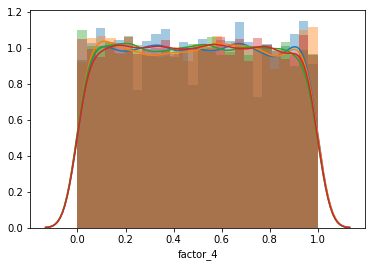

In [263]:
# Исследуем распределение 4 последних факторов
# И придем к выводу, что они все распределены нормально и не несут никакой информации
sns.distplot(segment.factor_1)
sns.distplot(segment.factor_2)
sns.distplot(segment.factor_3)
sns.distplot(segment.factor_4)

In [274]:
# По этой причине их можно отбросить
segment = segment.loc[:, ['CustomerId', 'Monetary', 'Recency', 'Frequency']]
segment.head()

,CustomerId,Monetary,Recency,Frequency
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5


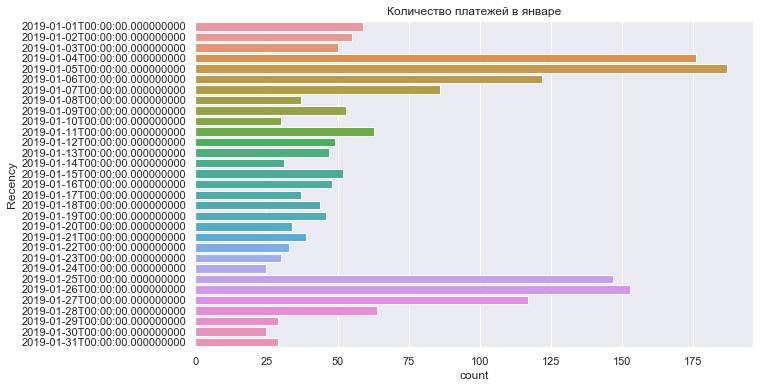

In [433]:
# Изучим поведение покупателей по месяцам
# Построим графики количества платежей по каждому месяцу
data = segment.loc[:, ['Recency']]
month = data[data['Recency'].dt.month == 1]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в январе')
sns.set(rc={'figure.figsize':(10, 6)})

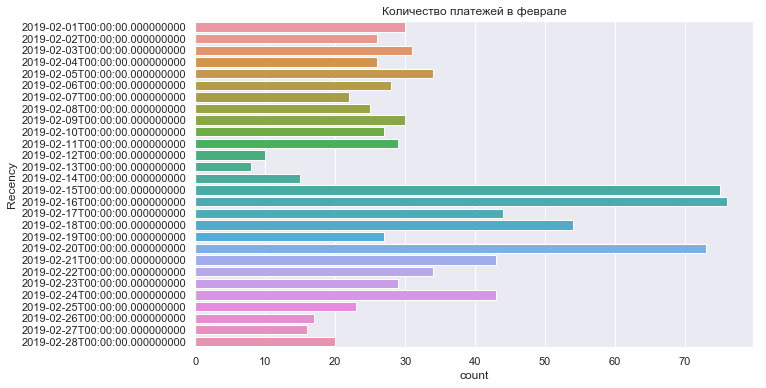

In [434]:
month = data[data['Recency'].dt.month == 2]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в феврале')
sns.set(rc={'figure.figsize':(10, 6)})

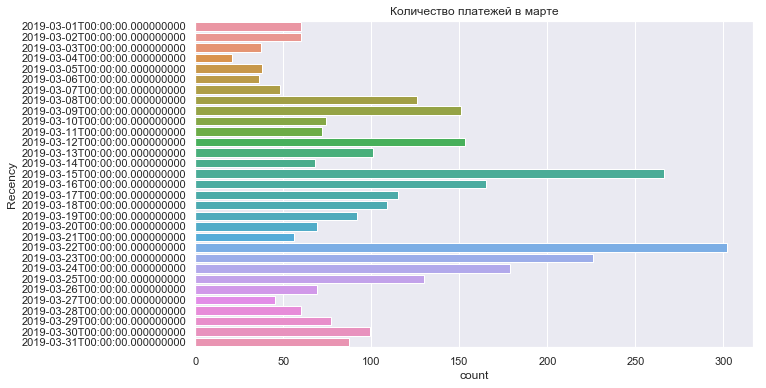

In [435]:
month = data[data['Recency'].dt.month == 3]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в марте')
sns.set(rc={'figure.figsize':(10, 6)})

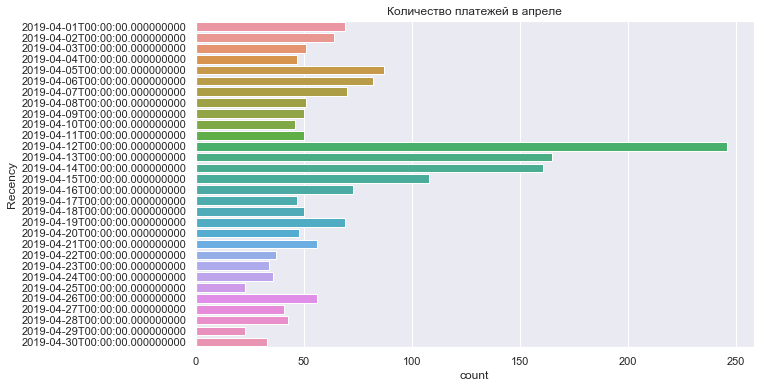

In [436]:
month = data[data['Recency'].dt.month == 4]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в апреле')
sns.set(rc={'figure.figsize':(10, 6)})

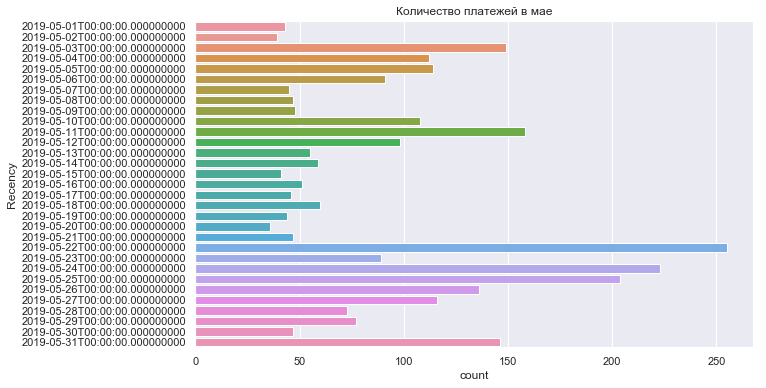

In [437]:
month = data[data['Recency'].dt.month == 5]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в мае')
sns.set(rc={'figure.figsize':(10, 6)})

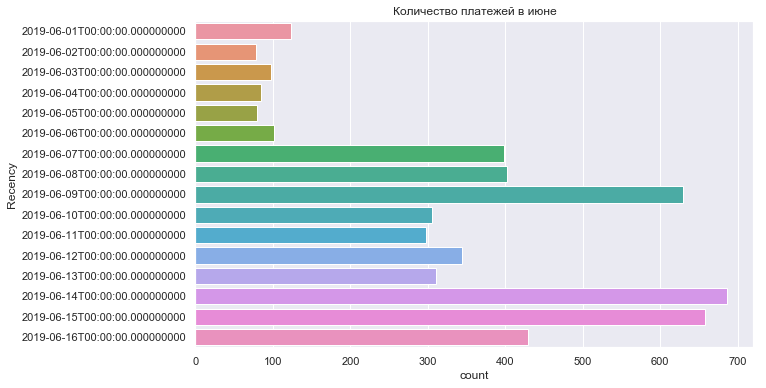

In [438]:
month = data[data['Recency'].dt.month == 6]
sns.countplot(y='Recency', data=month).set_title('Количество платежей в июне')
sns.set(rc={'figure.figsize':(10, 6)})

Общая тенденция такова, что все платежи в течение каждого месяца происходят равномерно, кроме некоторых дней в середине и в конце месяца. В феврале обнаружено наименьшее количество платежей, все последующие месяцы платежи происходили относительно равномерно. В июне виден подьем количества платежей. Скорее всего это связанно с какими-либо акциями компании или выпусками нового продукта. <br>
Если изучить количество вложенных средств в каждый месяц, то можно сделать следующие выводы: от начала года и до июня наблюдается постепенное увеличение количства вложенных средств, при этом разбросы значений колеблются от незначительных до изменения в 2-3 раза. Данный показатель было бы интерессно расмотреть подробнее в совокупности с различными видами пользователей (недовольных продуктом, слабо платящим, средними пользователями и охотно платящими). <br>
Хотя данный фактор несет много информации, я слабо понимаю, как его можно использовать для разделения пользователя на классы.

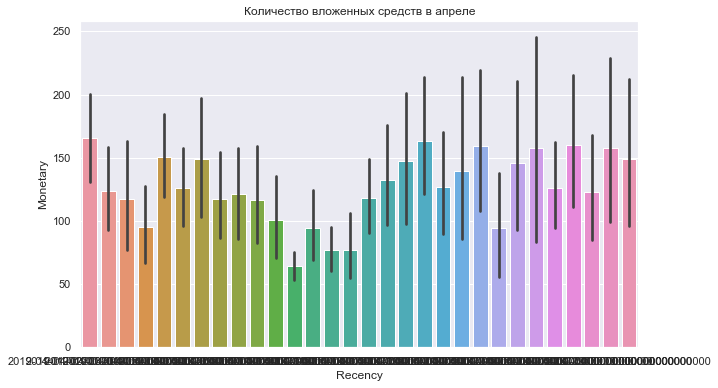

In [457]:
# Для примера приведем график количества вложенных средств в апреле
data = segment.loc[:, ['Recency', 'Monetary']]
month = data[(data['Recency'].dt.month == 4)]
sns.barplot(x='Recency', y='Monetary', data=month).set_title('Количество вложенных средств в апреле')
sns.set(rc={'figure.figsize':(10, 6)})

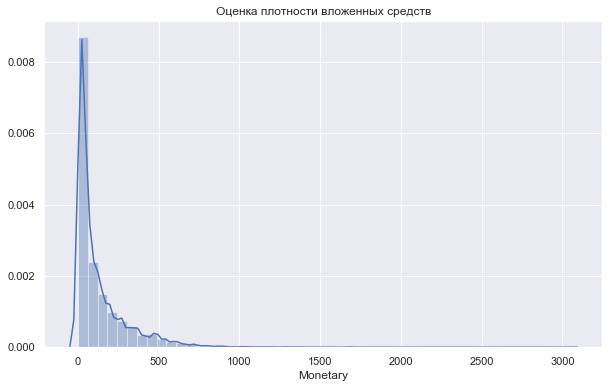

In [474]:
# Построим график плотности вложенных средств
sns.distplot(segment.Monetary).set_title('Оценка плотности вложенных средств');

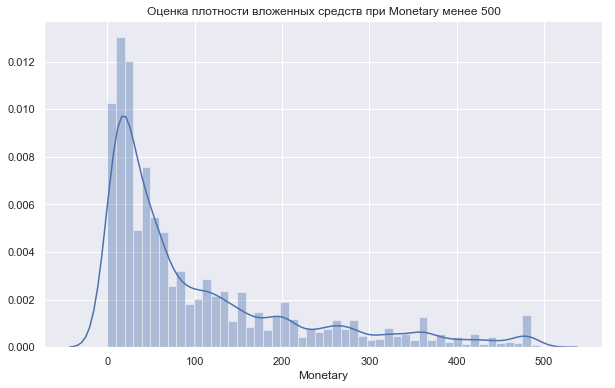

In [476]:
# Построим график плотности вложенных средств при Monetary менее 500
monetary_normal = segment[(segment['Monetary'] < 500)]
sns.distplot(monetary_normal.Monetary).set_title('Оценка плотности вложенных средств при Monetary менее 500');

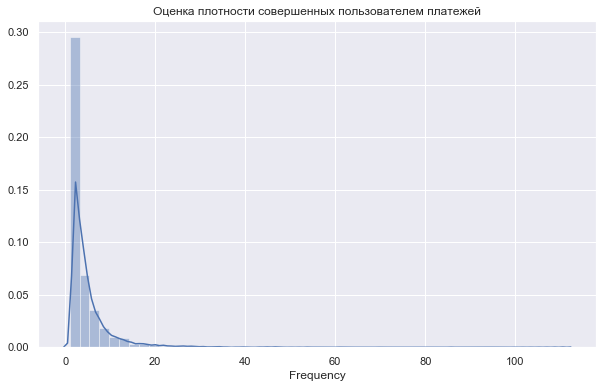

In [468]:
# Построим график плотности совершенных пользователем платежей
sns.distplot(segment.Frequency).set_title('Оценка плотности совершенных пользователем платежей');

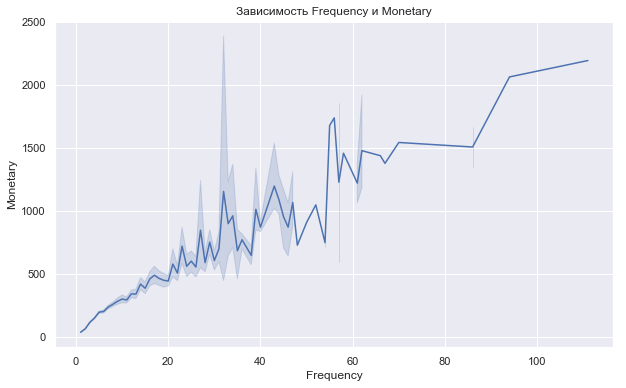

In [470]:
# Построим график зависимости Frequency и Monetary
data = segment.loc[:, ['Frequency', 'Monetary']]
sns.lineplot(x="Frequency", y="Monetary", data=data).set_title('Зависимость Frequency и Monetary');

In [479]:
# Построим таблицу с различными уровнями квантилей для объема вложенных средств и совершенных платежей
quantiles = [0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 0.975]
quantiles_table = pd.DataFrame(columns=['Quantile', 'Monetary', 'Frequency'])

for i in range(len(quantiles)):
    quantiles_table = quantiles_table.append({
        'Quantile': quantiles[i], 
        'Monetary': segment.Monetary.quantile(quantiles[i]), 
        'Frequency': segment.Frequency.quantile(quantiles[i])}, ignore_index=True)

quantiles_table

,Quantile,Monetary,Frequency
0,0.300,24.740,1.0
1,0.400,42.000,2.0
2,0.500,59.275,2.0
3,0.600,85.860,3.0
4,0.700,130.000,4.0
5,0.750,170.000,5.0
6,0.800,205.000,5.0
7,0.850,270.000,7.0
8,0.900,360.000,8.0
9,0.950,480.000,12.0


На основании полученных графиков, а также различных процентилей наших данных можно сделать следующие выводы. <br>
* 95% пользователей вкладывали свои средства не более 12 раз, а до этого значения график зависимости Frequency и Monetary идет фактически линейно. Также не стоит забывать про выявленную на раннем этапе высокую корреляцию между этими показателями.
* Frequency и Monetary имеют распределение вероятностей, очень похожее на логнормальное с очень длинным правым хвостом.
* При Frequency более 20 мы наблюдаем очень сильные скачки вложенных пользователем средств, а также потерю линейного вида графика. Это связанно с тем, что количество таких наблюдений достотачно мало по сравнению с остальными. Всех таких пользователей можно сразу относить к классу пользователей, которые охотно приносят в нашу компанию наибольшие вложения.

Мной было предложено следующее разделение на 6 классов пользователей (основываясь на описанных выше результатах):
* (0) Пользователи, которым не понравился продукт и которые отказались от его использования - порядка 30% от всех, их количество платежей = 1 и размер платежей менее 25.
* (1) Пользователи, которые приносят минимум средств компании - их количество платежей - 1-2 и размер их платежей более 25, но менее 60.
* (2) Средний пользователь - их количество платежей от 2 до 6 и размер их платежей от 60 до 300.
* (3) Пользователи, которые приносят высокий доход компании - те пользователи, чей размер платежей от 300 до 600 и количество их платежей более 3.
* (4) Пользователи, приносящие наибольшие средства - те пользователи, чей размер платеже более 600.
* (5) Прочие пользователи - которые не попали ни в один из других типов. Для анализа таких пользователей необходимы дополнителые исследования.

In [537]:
# Введем дополнительный столбец для каждого из видов пользователей
segment_new = segment.copy()
segment_new['class'] = None

# Изначально присвоим всем классам значение 5 (прочие пользователи)
segment_new.loc[:, ['class']] = 5 

# Пользователи, которым не понравился продукт и которые отказались от его использования
segment_new.at[(segment['Monetary'] <= 25) & (segment['Frequency'] == 1), ['class']] = 0

# Пользователи, которые приносят минимум средств компании
segment_new.at[(segment['Monetary'] > 25) & (segment['Monetary'] <= 60) & (segment['Frequency'] <= 2), ['class']] = 1

# Средние пользователи
segment_new.at[(segment['Monetary'] > 60) & (segment['Monetary'] <= 300) & (segment['Frequency'] <= 6) &
               (segment['Frequency'] >= 2), ['class']] = 2

# Пользователи, которые приносят высокий доход компании
segment_new.at[(segment['Monetary'] > 300) & (segment['Monetary'] <= 600) & (segment['Frequency'] >= 3), ['class']] = 3

# Пользователи, приносящие наибольшие средства
segment_new.at[(segment['Monetary'] > 600), ['class']] = 4

segment_new.head()

# По уму нужно было еще посчитать среднюю цену продукта компании, 
# самый дешевый продукт компании и самый дорогой продукт компании,
# чтобы на это опираться, разделяя пользователей на классы,
# Но я понял это слишком поздно

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,class
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383,2
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846,2
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076,2
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974,5
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194,2


In [527]:
# Показажем средние значения факторов в разных кластерах
print('Кол-во и среднее класса 0')
segment_new[segment_new['class'] == 0].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 0


,Monetary,Frequency,factor_1,factor_2,factor_3
count,3652.00000,3652.0,3652.000000,3652.000000,3652.000000
mean,12.47144,1.0,0.502442,0.494064,0.498857


In [528]:
print('Кол-во и среднее класса 1')
segment_new[segment_new['class'] == 1].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 1


,Monetary,Frequency,factor_1,factor_2,factor_3
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,41.538734,1.448122,0.498918,0.500581,0.494416


In [529]:
print('Кол-во и среднее класса 2')
segment_new[segment_new['class'] == 2].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 2


,Monetary,Frequency,factor_1,factor_2,factor_3
count,3959.000000,3959.000000,3959.00000,3959.000000,3959.000000
mean,139.738838,3.759788,0.50093,0.501268,0.493851


In [530]:
print('Кол-во и среднее класса 3')
segment_new[segment_new['class'] == 3].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 3


,Monetary,Frequency,factor_1,factor_2,factor_3
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,416.692869,9.543583,0.489087,0.515601,0.493761


In [531]:
print('Кол-во и среднее класса 4')
segment_new[segment_new['class'] == 4].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 4


,Monetary,Frequency,factor_1,factor_2,factor_3
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,855.463608,20.778351,0.505387,0.480464,0.498777


In [532]:
print('Кол-во и среднее класса 5')
segment_new[segment_new['class'] == 5].describe().iloc[0:2, 0:5]

Кол-во и среднее класса 5


,Monetary,Frequency,factor_1,factor_2,factor_3
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,104.192772,4.519266,0.500873,0.492115,0.494842


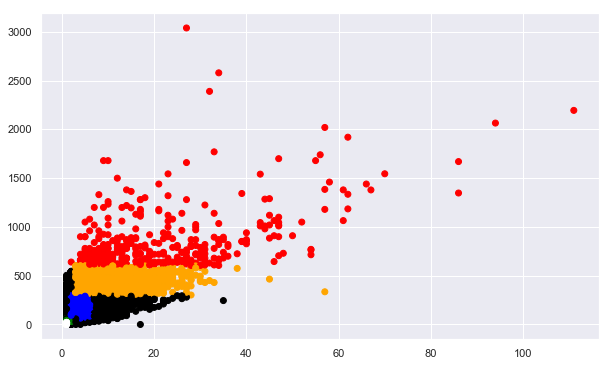

In [560]:
# Визуализируем получившиеся кластеры
y = segment_new.iloc[:, 1].values
x = segment_new.iloc[:, 3].values
color = segment_new['class'].map({
    0: 'white',
    1: 'green', 
    2: 'blue', 
    3: 'orange',
    4: 'red',
    5: 'black'})

plt.scatter(x, y, c=color);

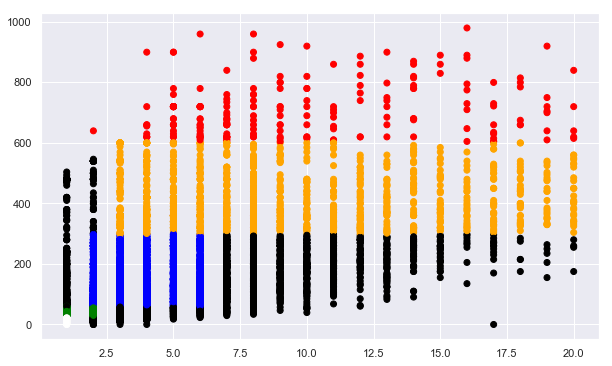

In [561]:
# И немного детальней
xy_new = segment_new[(segment_new['Monetary'] <= 1000) & (segment_new['Frequency'] <= 20)]

y = xy_new.iloc[:, 1].values
x = xy_new.iloc[:, 3].values
color = xy_new['class'].map({
    0: 'white',
    1: 'green', 
    2: 'blue', 
    3: 'orange',
    4: 'red',
    5: 'black'})

plt.scatter(x,y, c=color);

Осталось отметить признаки, не несущие какой-либо информации:
* CustomerId (может и необходим уже после построения модели, чтобы сопоставлять пользователей и классы, но для анализа он бесполезен)
* factor_1
* factor_2
* factor_3
* factor_4